## Analysis of Buck Converter Data

The simulation data was saved as a hdf5 database in the folder: C:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\Databases. 

In [ ]:
from pathlib import Path
import h5py

from pinn_buck.h5_funcs import explore_h5

directory = Path(r"C:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\Databases")
db_name = "buck_converter_Shuai"

explore_h5(directory / f"{db_name}")

[1] Group   original_format
	[2] Group   original_format/0
		[3] Dataset original_format/0/Current - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/CurrentInput - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/CurrentInputLower - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/Dswitch - shape: (1440, 1), dtype: uint8
		[3] Dataset original_format/0/DswitchLower - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/DswitchTransform - shape: (1440, 1), dtype: uint16
		[3] Dataset original_format/0/Rload - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/RloadLower - shape: (722, 1), dtype: float64
		[3] Dataset original_format/0/Voltage - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/VoltageInput - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/VoltageInputLower - shape: (1440, 1), dtype: float64
		[3] Dataset original_format/0/dt - shape: (1440, 1), dtype: float64
		[3]

In [2]:
# check the attributes of the first group
macrogroup_name = "original_format"
with h5py.File(directory / f"{db_name}.h5", "r") as f:
    print(f"Attributes of the first group '{macrogroup_name}':")
    for attr in f[macrogroup_name].attrs:
        print(f"{attr}: {f[macrogroup_name].attrs[attr]}")

Attributes of the first group 'original_format':
created_by: load_simul_data.py script
created_on: 2025-06-06T09:24:01.989233
description: 
            From the paper: 
                S. Zhao, Y. Peng, Y. Zhang and H. Wang, "Parameter Estimation of Power Electronic Converters 
                With Physics-Informed Machine Learning," in IEEE Transactions on Power Electronics, vol. 37, 
                no. 10, pp. 11567-11578, Oct. 2022, doi: 10.1109/TPEL.2022.3176468. 
                
            This data contains the original simulation data loaded from MATLAB .mat files
            Each subgroup corresponds to different experiments (Table II): 
                1. Clean Data (0.1)
                2. ADC error (0.1)
                3. Sync error (1.6)
                4. 5 noise (0.8)
                5. 10 noise (2.1)
                6. ADC-Sync-5noise (3.6)
                7. ADC-Sync-10noise (4.9)
            In each subgroup, the data is organized as follows: 
                +	"Cu

## Ideal Case

For now we are interested in analyzing the ideal case of a noiseless simulation. This corresponds to the first group. 

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File(directory / f"{db_name}.h5", "r") as f:
    used_keys = [
        "CurrentInput",
        "VoltageInput",
        "Dswitch",
        "Current",
        "Voltage",
        "forwaredBackwaredIndicator",
        "dt",
    ]

    print("Of these, the used keys are:")
    print(used_keys)

    group = f[f"{macrogroup_name}/0"]
    keys = list(filter(lambda x: "__" not in x, group.keys()))

    if not all([k in keys for k in used_keys]):
        print(
            """
    ---------------------------------------
    Warning! Keys are not in the dataset
    ---------------------------------------
    """
        )

    unused_keys = list(filter(lambda x: x not in used_keys, keys))

    print("Therefore, the other keys hold data that is not used in the code:")
    print(unused_keys)

# Extract the used datasets
with h5py.File(directory / f"{db_name}.h5", "r") as f:
    group = f[f"{macrogroup_name}/0"]
    
    # i_L datasets
    i_: np.ndarray = group["Current"][:].squeeze()
    i_in: np.ndarray = group["CurrentInput"][:].squeeze()

    # v datasets
    v_: np.ndarray = group["Voltage"][:].squeeze()
    v_in: np.ndarray = group["VoltageInput"][:].squeeze()
    
    
    # t datasets
    dt: np.ndarray = group["dt"][:].squeeze()

    
    # d switch datasets
    d_switch: np.ndarray = group["Dswitch"][:].squeeze().astype(np.int32)
    
    # forward and backward indicator
    fb_indicator: np.ndarray = group["forwaredBackwaredIndicator"][:].squeeze()

# Print the shapes of the extracted dataset

Of these, the used keys are:
['CurrentInput', 'VoltageInput', 'Dswitch', 'Current', 'Voltage', 'forwaredBackwaredIndicator', 'dt']
Therefore, the other keys hold data that is not used in the code:
['CurrentInputLower', 'DswitchLower', 'DswitchTransform', 'Rload', 'RloadLower', 'VoltageInputLower', 'res', 't', 'tLower']


# We can break up the three transients

We can use pandas to inspect the index of the jump in values, where there is no longer consistency of pairs

In [4]:
import pandas as pd

def pairwise_diff_df(arr: np.ndarray, name="array"):
    """
    Builds a pandas DataFrame comparing all non-overlapping pairs of rows:
    (0,1), (2,3), (4,5), ...
    
    Shows original values and absolute differences.
    """
    assert arr.shape[0] % 2 == 0, "Array must have even number of rows for pairwise comparison."
    if np.ndim(arr) == 1: 
        arr = arr[:, np.newaxis]

    num_pairs = arr.shape[0] // 2
    col_names = [f"{name}_{i}" for i in range(arr.shape[1])]
    data = []

    for i in range(num_pairs):
        idx_a = 2 * i
        idx_b = 2 * i + 1
        row_a = arr[idx_a]
        row_b = arr[idx_b]
        delta = np.abs(row_b - row_a)
        row_dict = {
            "index_a": idx_a,
            "index_b": idx_b,
            **{f"a_{c}": v for c, v in zip(col_names, row_a)},
            **{f"b_{c}": v for c, v in zip(col_names, row_b)},
            **{f"Delta": d for c, d in zip(col_names, delta)},
        }
        data.append(row_dict)

    df = pd.DataFrame(data)
    return df

In [5]:
## V_in
print("We start with the V_in dataset as an example:")
print("The number of elements in v_in is:", len(v_in))

print("There are three positions in which the pairs are not equal:")
print(pairwise_diff_df(v_in, name="V_in").sort_values(by=["Delta"], ascending=False).head(4))

print("We see that the indices are 148 -> 149, 958-> 959, and 478->479.")
print("It can be noted, that 1440/3 = 480, so the indices are multiples of 480, minus 1 for the numbering in python.")
print("All the subtransients of V_in start with idenical pairs, but the last two values are different!")

# V_
print("Now we can check the V_ dataset:")
print("The number of elements in v_ is:", len(v_))
print("Looking at the positions in which the pairs are not equal:")
print(pairwise_diff_df(v_[1:-1], name="V_").sort_values(by=["Delta"], ascending=False).head(4))

print("The V dataset starts with a free value and only from the second value on, the pairs are identical.")
print("Therefore, it was necessary to remove the first value from the dataset to get the pairing right. But the last value must also be removed to get an even number of rows.")
print(
    "Adding 1 to the indices shown, the indices of the differences are 959 -> 960, 479 -> 480"
)
print("It can be seen that in this case the non identical pairs are the end value and the beginning value of the next subtransient, which are still obtainable by dividing the length by 3.")

def separate_transients(
    input_quantity: np.ndarray, 
) -> list:
    """
    Separates the input quantity into subtransients.
    """
    subtransients = []
    total_length = len(input_quantity)
    if not total_length % 3 == 0:
        raise ValueError("The length of the input quantity must be a multiple of 3.")
    subtransient_length = total_length // 3
    for i in range(3):
        start_idx = i * subtransient_length
        end_idx = start_idx + subtransient_length
        subtransients.append(input_quantity[start_idx:end_idx])
    return subtransients

v_in_subtransients = separate_transients(v_in)
v_subtransients = separate_transients(v_)

i_in_subtransients = separate_transients(i_in)
i_subtransients = separate_transients(i_)

We start with the V_in dataset as an example:
The number of elements in v_in is: 1440
There are three positions in which the pairs are not equal:
     index_a  index_b   a_V_in_0   b_V_in_0     Delta
719     1438     1439  23.898277  20.330918  3.567359
479      958      959  24.057189  22.113152  1.944037
239      478      479  23.899845  25.073282  1.173437
2          4        5  19.818609  19.818609  0.000000
We see that the indices are 148 -> 149, 958-> 959, and 478->479.
It can be noted, that 1440/3 = 480, so the indices are multiples of 480, minus 1 for the numbering in python.
All the subtransients of V_in start with idenical pairs, but the last two values are different!
Now we can check the V_ dataset:
The number of elements in v_ is: 1440
Looking at the positions in which the pairs are not equal:
     index_a  index_b     a_V__0     b_V__0     Delta
479      958      959  23.899539  22.170408  1.729131
239      478      479  24.042750  24.943378  0.900627
4          8        9

Text(0.5, 0.98, 'Subtransients of Voltages and Currents')

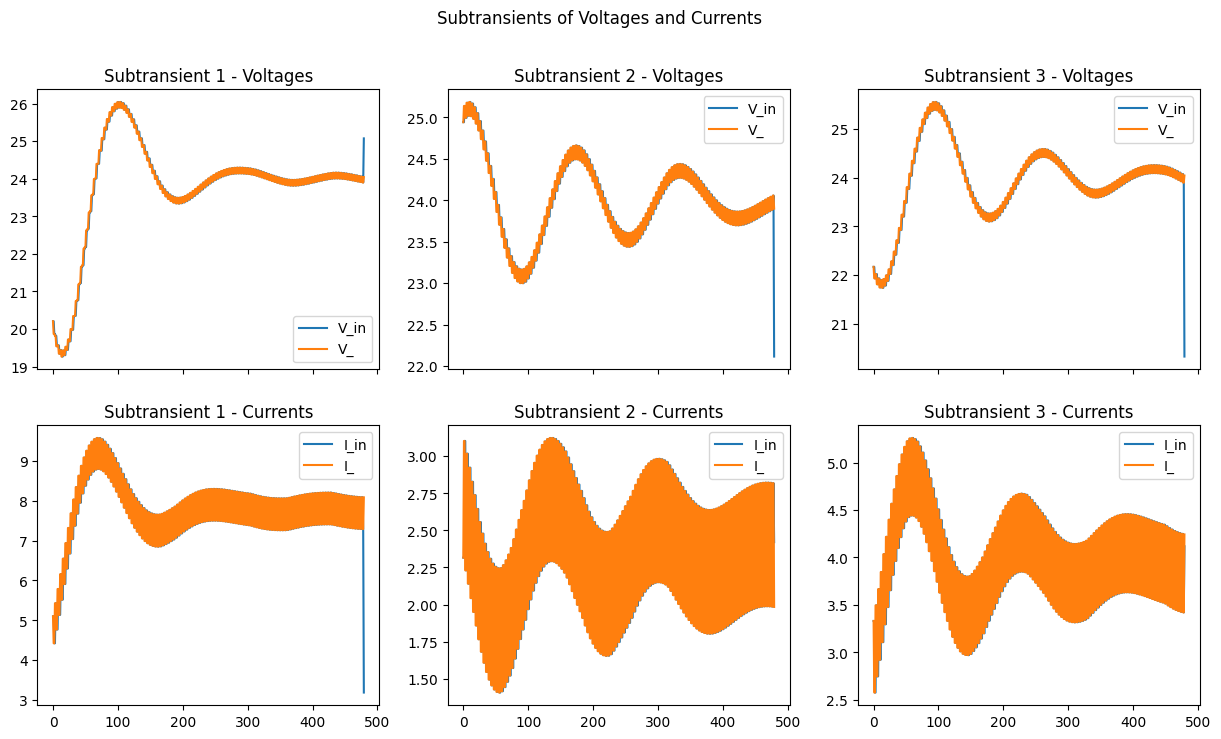

In [6]:
# plot the subtransients
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
for i, (v_in_sub, v_sub, i_in_sub, i_sub) in enumerate(
    zip(v_in_subtransients, v_subtransients, i_in_subtransients, i_subtransients)
):
    ax[0, i].plot(v_in_sub, label="V_in")
    ax[0, i].plot(v_sub, label="V_")
    ax[0, i].set_title(f"Subtransient {i+1} - Voltages")
    ax[0, i].legend()
    
    ax[1, i].plot(i_in_sub, label="I_in")
    ax[1, i].plot(i_sub, label="I_")
    ax[1, i].set_title(f"Subtransient {i+1} - Currents")
    ax[1, i].legend()
    
fig.suptitle("Subtransients of Voltages and Currents")

In [7]:
print("Now we can look at the Dswitch dataset:")
print("Looking at the non-identical pairs of the Dswitch dataset:")
print(pairwise_diff_df(d_switch).sort_values(by=["Delta"], ascending=False).head(4))
print("We see that the situation is similar to the V_in and I_in datasets, were the non-identical pairs are at the end of the subtransients. But not at the end of the last one!")

print("The dt dataset has a length of", len(d_switch))
print("But it has no non-identical pairs:")
print(pairwise_diff_df(dt).sort_values(by=["Delta"], ascending=False).head(4))

Now we can look at the Dswitch dataset:
Looking at the non-identical pairs of the Dswitch dataset:
     index_a  index_b  a_array_0  b_array_0  Delta
239      478      479          1          0      1
479      958      959          0          1      1
1          2        3          1          1      0
2          4        5          0          0      0
We see that the situation is similar to the V_in and I_in datasets, were the non-identical pairs are at the end of the subtransients. But not at the end of the last one!
The dt dataset has a length of 1440
But it has no non-identical pairs:
     index_a  index_b  a_array_0  b_array_0  Delta
703     1406     1407   0.000027   0.000027    0.0
702     1404     1405   0.000023   0.000023    0.0
701     1402     1403   0.000027   0.000027    0.0
700     1400     1401   0.000023   0.000023    0.0


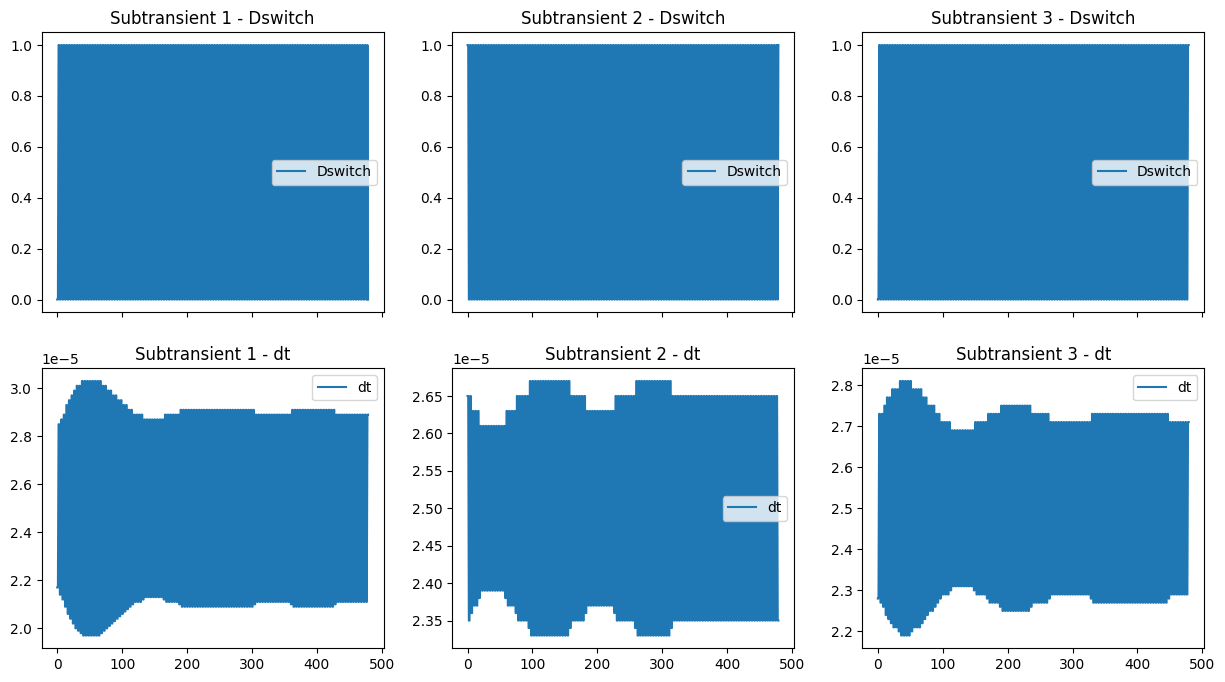

In [8]:
d_switch_subtransients = separate_transients(d_switch)
dt_subtransients = separate_transients(dt)

# Plot the Dswitch and dt subtransients
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
for i, (d_switch_sub, dt_sub) in enumerate(zip(d_switch_subtransients, dt_subtransients)):
    ax[0, i].plot(d_switch_sub, label="Dswitch")
    ax[0, i].set_title(f"Subtransient {i+1} - Dswitch")
    ax[0, i].legend()
    
    ax[1, i].plot(dt_sub, label="dt")
    ax[1, i].set_title(f"Subtransient {i+1} - dt")
    ax[1, i].legend()

## Remove Doubled Values from Transients
Voltages: 

In [10]:
print("The idea of the paper is to obtain pairs of values (starting peak, ending peak) for the monitored quanties.")
print("We can create the pairs by stacking the input and output vectors, using the voltage as an example.")
v_in1 = v_in_subtransients[0]
v_1 = v_subtransients[0]

x_v1 = np.stack((v_in1, v_1), axis=1)

print("The shape of the stacked array is:", x_v1.shape)
print("The first 6 values of the stacked array:")
print(x_v1[:6])
print("The last 6 values of the stacked array:")
print(x_v1[-6:])


print("We can see that every second row holds the same values. This is because the vectors save pairs of identical data.")
print("Furthermore, we see that the first row holds such identcal values, while the last row holds different values but the start point is not the same as the end point of the previous subtransient.")
print("Therefore, we can remove the first and last row to get the pairs of values for the subtransient.")
x = x_v1[1:-1:2]

print("The shape of the final stacked array is:", x.shape)
print("The first 3 values of the final stacked array:")
print(x[:3])
print("The last 3 values of the final stacked array:")
print(x[-3:])

The idea of the paper is to obtain pairs of values (starting peak, ending peak) for the monitored quanties.
We can create the pairs by stacking the input and output vectors, using the voltage as an example.
The shape of the stacked array is: (480, 2)
The first 6 values of the stacked array:
[[20.20704443 20.20704443]
 [20.20704443 19.86835186]
 [19.86835186 19.86835186]
 [19.86835186 19.81860864]
 [19.81860864 19.81860864]
 [19.81860864 19.54136127]]
The last 6 values of the stacked array:
[[23.91392157 23.91392157]
 [23.91392157 24.05653036]
 [24.05653036 24.05653036]
 [24.05653036 23.89984512]
 [23.89984512 23.89984512]
 [25.07328191 24.04275029]]
We can see that every second row holds the same values. This is because the vectors save pairs of identical data.
Furthermore, we see that the first row holds such identcal values, while the last row holds different values but the start point is not the same as the end point of the previous subtransient.
Therefore, we can remove the first a

In [11]:
v_in_subtransients = list(map(lambda x: x[1:-1:2], v_in_subtransients))
v_subtransients = list(map(lambda x: x[1:-1:2], v_subtransients))
i_in_subtransients = list(map(lambda x: x[1:-1:2], i_in_subtransients))
i_subtransients = list(map(lambda x: x[1:-1:2], i_subtransients))
d_switch_subtransients = list(map(lambda x: x[1:-1:2], d_switch_subtransients))
dt_subtransients = list(map(lambda x: x[1:-1:2], dt_subtransients))

Text(0.5, 0.98, 'Subtransients of Dswitch and dt after pairing')

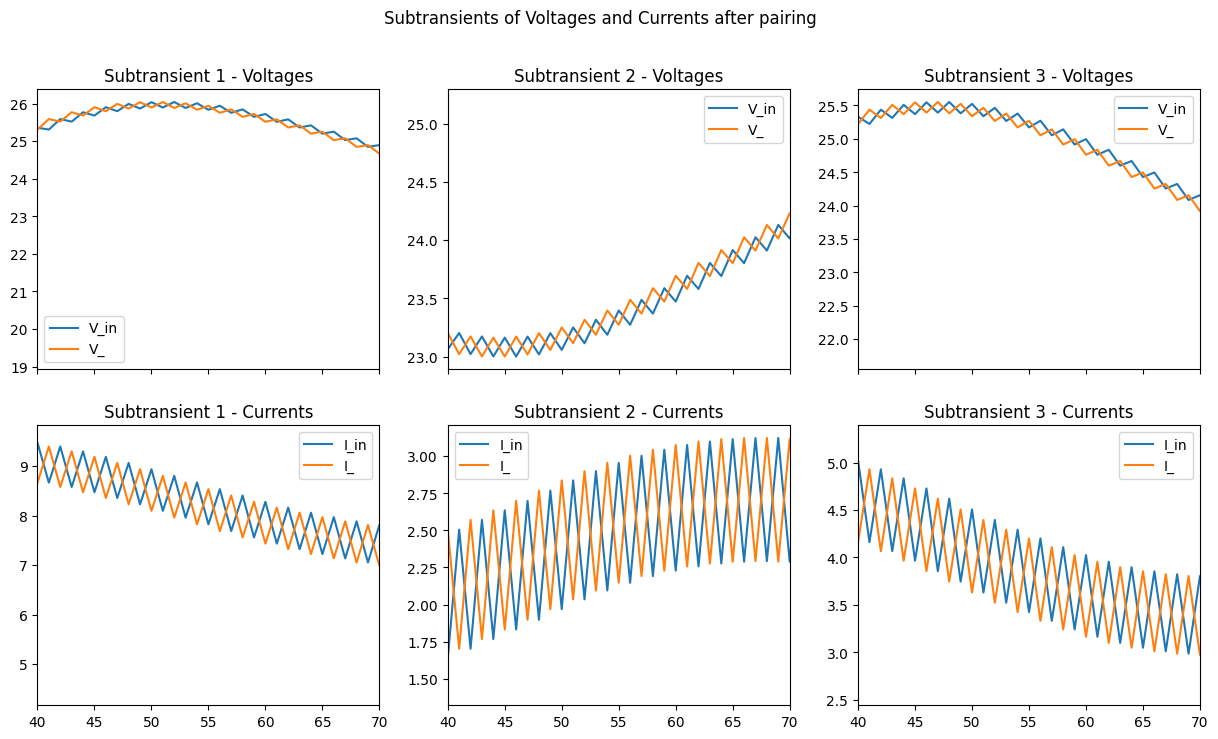

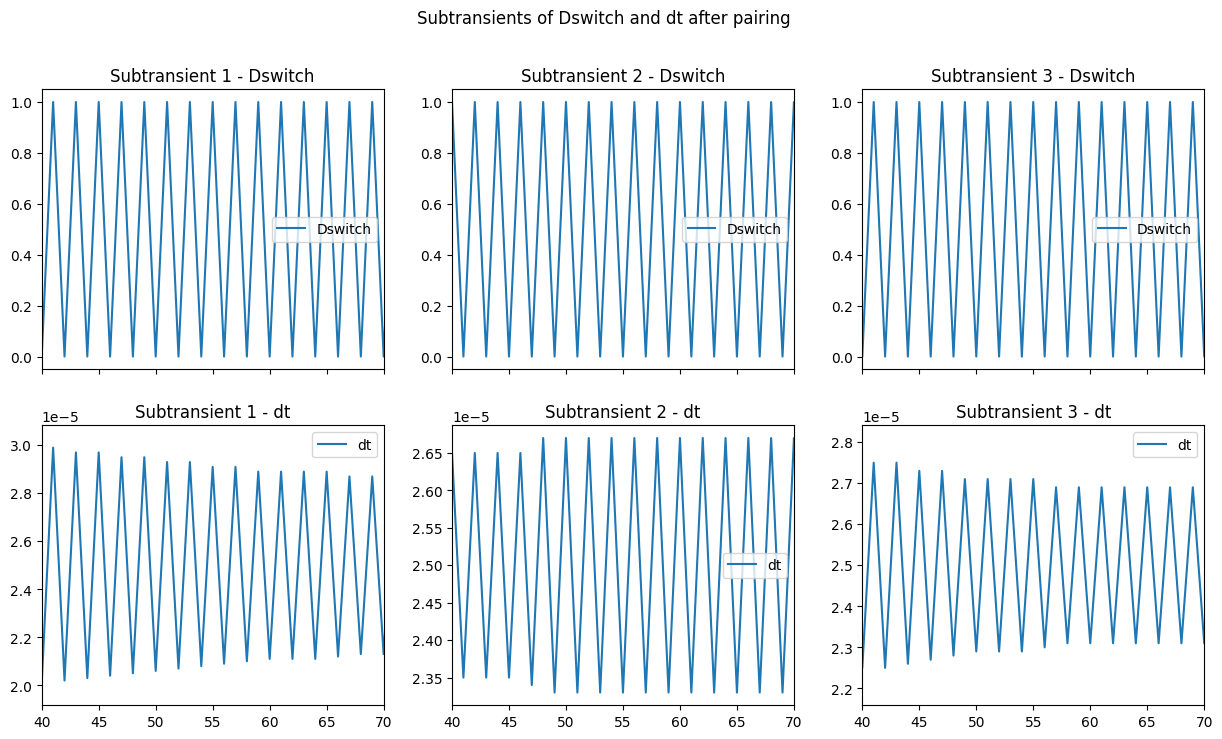

In [12]:
# plot the subtransients again
fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
for i, (v_in_sub, v_sub, i_in_sub, i_sub) in enumerate(
    zip(v_in_subtransients, v_subtransients, i_in_subtransients, i_subtransients)
):
    ax[0, i].plot(v_in_sub, label="V_in")
    ax[0, i].plot(v_sub, label="V_")
    ax[0, i].set_title(f"Subtransient {i+1} - Voltages")
    ax[0, i].legend()
    
    ax[1, i].plot(i_in_sub, label="I_in")
    ax[1, i].plot(i_sub, label="I_")
    ax[1, i].set_title(f"Subtransient {i+1} - Currents")
    ax[1, i].legend()
ax[0, 0].set_xlim(40, 70) 
fig.suptitle("Subtransients of Voltages and Currents after pairing")

fig, ax = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
for i, (d_switch_sub, dt_sub) in enumerate(zip(d_switch_subtransients, dt_subtransients)):
    ax[0, i].plot(d_switch_sub, label="Dswitch")
    ax[0, i].set_title(f"Subtransient {i+1} - Dswitch")
    ax[0, i].legend()
    
    ax[1, i].plot(dt_sub, label="dt")
    ax[1, i].set_title(f"Subtransient {i+1} - dt")
    ax[1, i].legend()
    
ax[0, 0].set_xlim(40, 70)
fig.suptitle("Subtransients of Dswitch and dt after pairing")

## Recover Original Signals

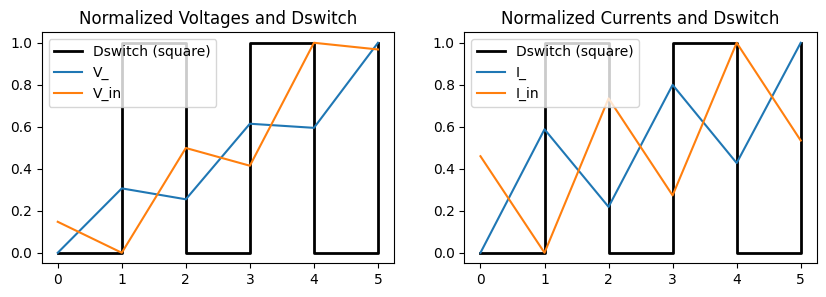

In [13]:
# The it can be seen that the currents and voltages have duplicated values in V and V_in, and I and I_in.
# First we can compare the values of the voltage and currents with the values of the Dswitch and dt datasets.
# let's normalize the values since we are only interested in monitoring the behavior of the system.

v_test = v_subtransients[0][10:16]
v_in_test = v_in_subtransients[0][10:16]
i_test = i_subtransients[0][10:16]
i_in_test = i_in_subtransients[0][10:16]

v_norm = (v_test - np.min(v_test)) / (np.max(v_test) - np.min(v_test))
v_in_norm = (v_in_test - np.min(v_in_test)) / (np.max(v_in_test) - np.min(v_in_test))

i_norm = (i_test - np.min(i_test)) / (np.max(i_test) - np.min(i_test))
i_in_norm = (i_in_test - np.min(i_in_test)) / (np.max(i_in_test) - np.min(i_in_test))

d_switch_norm = d_switch_subtransients[0][10:16]


def to_square_wave(arr):
    # Repeat each value, except the last, to create a step effect
    arr = np.asarray(arr)
    x = np.repeat(np.arange(len(arr)), 2)[1:]
    y = np.repeat(arr, 2)[:-1]
    return x, y
x_sq, y_sq = to_square_wave(d_switch_norm)

fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharex=True)
ax[0].plot(x_sq, y_sq, "k-", linewidth=2, label="Dswitch (square)")
ax[0].plot(v_norm, label="V_")
ax[0].plot(v_in_norm, label="V_in")
ax[0].set_title("Normalized Voltages and Dswitch")
ax[0].legend()

ax[1].plot(x_sq, y_sq, "k-", linewidth=2, label="Dswitch (square)")
ax[1].plot(i_norm, label="I_")
ax[1].plot(i_in_norm, label="I_in")
ax[1].set_title("Normalized Currents and Dswitch")
ax[1].legend(loc="upper left")

In [20]:
# Although the values of V_in, V and I_in, I are respectively identical with a shift (except for the first and last values),
# from the plot we can see that V_in and I_in are the ones that behave correctly with respect to the Dswitch dataset.

# Therefore, we chose to keep the V_in and I_in datasets as the input values, and V and I as the output values.
v = v_in_subtransients
i = i_in_subtransients

# we can also recover the time vector by cumulating the dt values.
t_subtransients = [np.cumsum(dt_sub) for dt_sub in dt_subtransients]

# final quantities
final_quantities = {
    "t": t_subtransients,
    "v": v,
    "i": i,
    "Dswitch": d_switch_subtransients,
    "dt": dt_subtransients,
}

In [22]:
## Save the final quantities to a new HDF5 file
output_file = directory / f"{db_name}_processed.h5"

# save the different transients as different groups under the macrogroup "ideal"

with h5py.File(output_file, "w") as f:
    macrogroup = f.create_group("ideal")
    
    for ii, (t_val, v_val, i_val, d_switch_val, dt_val) in enumerate(
        zip(t_subtransients, v, i, d_switch_subtransients, dt_subtransients)
    ):
        # note that v0 and i0 are floats, while the rest are arrays
        subgroup = macrogroup.create_group(f"subtransient_{ii+1}")
        subgroup.create_dataset("t", data=t_val)
        subgroup.create_dataset("v", data=v_val)
        subgroup.create_dataset("i", data=i_val)
        subgroup.create_dataset("Dswitch", data=d_switch_val)
        subgroup.create_dataset("dt", data=dt_val)
    print(f"Processed data saved to {output_file}")

Processed data saved to C:\Users\JC28LS\OneDrive - Aalborg Universitet\Desktop\Work\Databases\buck_converter_Shuai_processed.h5


In [23]:
explore_h5(output_file)

[1] Group   ideal
	[2] Group   ideal/subtransient_1
		[3] Dataset ideal/subtransient_1/Dswitch - shape: (239,), dtype: int32
		[3] Dataset ideal/subtransient_1/dt - shape: (239,), dtype: float64
		[3] Dataset ideal/subtransient_1/i - shape: (239,), dtype: float64
		[3] Dataset ideal/subtransient_1/t - shape: (239,), dtype: float64
		[3] Dataset ideal/subtransient_1/v - shape: (239,), dtype: float64
	[2] Group   ideal/subtransient_2
		[3] Dataset ideal/subtransient_2/Dswitch - shape: (239,), dtype: int32
		[3] Dataset ideal/subtransient_2/dt - shape: (239,), dtype: float64
		[3] Dataset ideal/subtransient_2/i - shape: (239,), dtype: float64
		[3] Dataset ideal/subtransient_2/t - shape: (239,), dtype: float64
		[3] Dataset ideal/subtransient_2/v - shape: (239,), dtype: float64
	[2] Group   ideal/subtransient_3
		[3] Dataset ideal/subtransient_3/Dswitch - shape: (239,), dtype: int32
		[3] Dataset ideal/subtransient_3/dt - shape: (239,), dtype: float64
		[3] Dataset ideal/subtransient_3/i 